In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import dependencies

import numpy as np

import torch
import random

SEED = 42
torch.manual_seed(42)  # Fixes the seed for PyTorch
np.random.seed(42)  # Fixes the seed for NumPy
random.seed(42)  # Fixes the seed for Python's random module

SLIDING_WINDOW_SIZE = 10

In [3]:
# Load data
import helpers
import os
import pandas as pd

action_folders = [
    "badminton",
    "boxing",
    "fencing",
    "golf",
    "logout",
    "reload",
    "shield",
    "snowbomb",
]
tuples = []
# test_tuples = []
viable_files = ["yr", "nix", "yp", "akhil", "mc"]
# viable_files = ["yr2", "nix2", "yp2"]

for idx, folder in enumerate(action_folders):
    data_path = os.path.join("dataset", folder)
    for csv_file in os.listdir(data_path):
        dataframe = pd.read_csv(os.path.join(data_path, csv_file))
        for header in viable_files:
            if not csv_file.startswith("augmented_"+header):
                # test_tuples.append((dataframe, idx))
                continue
            else:
                tuples.append((dataframe, idx))

x, y = helpers.generate_data(tuples, features=["acceleration_x", "acceleration_y", "acceleration_z", "gyro_x", "gyro_y", "gyro_z"], window_size=SLIDING_WINDOW_SIZE, stride=SLIDING_WINDOW_SIZE)
# x_test, y_test = helpers.generate_data(test_tuples, features=["acceleration_x", "acceleration_y", "acceleration_z", "gyro_x", "gyro_y", "gyro_z"], window_size=SLIDING_WINDOW_SIZE, stride = SLIDING_WINDOW_SIZE)


print("Shape of feature vector is " + str(x.shape))
print("Shape of output vector is " + str(y.shape))

Shape of feature vector is (2739, 10, 6)
Shape of output vector is (2739,)


In [4]:
# Split data
from sklearn.model_selection import train_test_split

# raw_x_train, raw_x_test, y_train, y_test = x, x_test, y, y_test

raw_x_train, raw_x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)

print("Shape of raw_x_train is " + str(raw_x_train.shape))
print("Shape of y_train is " + str(y_train.shape))
print("Shape of raw_x_test is " + str(raw_x_test.shape))
print("Shape of y_test is " + str(y_test.shape))

Shape of raw_x_train is (2191, 10, 6)
Shape of y_train is (2191,)
Shape of raw_x_test is (548, 10, 6)
Shape of y_test is (548,)


In [5]:
# Extract features

x_train = helpers.convert_time_series_to_features(raw_x_train)
print("Shape of training feature vector is " + str(x_train.shape))

x_test = helpers.convert_time_series_to_features(raw_x_test)
print("Shape of testing feature vector is " + str(x_test.shape))

Shape of training feature vector is (2191, 108)
Shape of testing feature vector is (548, 108)


In [6]:
# Normalize data

from sklearn.preprocessing import StandardScaler
import pickle

scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

print("Shape of training feature vector is " + str(x_train.shape))
print("Shape of testing feature vector is " + str(x_test.shape))

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

Shape of training feature vector is (2191, 108)
Shape of testing feature vector is (548, 108)


Epoch 0 Loss 2.081003189086914
Epoch 100 Loss 1.5702733993530273
Epoch 200 Loss 1.540479302406311
Epoch 300 Loss 1.5367814302444458
Epoch 400 Loss 1.5357307195663452
Epoch 500 Loss 1.5352473258972168
Epoch 600 Loss 1.5349364280700684
Epoch 700 Loss 1.534722924232483
Epoch 800 Loss 1.5345757007598877
Epoch 900 Loss 1.534468650817871
Epoch 1000 Loss 1.5344010591506958
Epoch 1100 Loss 1.5343337059020996
Epoch 1200 Loss 1.5342824459075928
Epoch 1300 Loss 1.5342414379119873
Epoch 1400 Loss 1.5341992378234863
Accuracy on training set is 0.8366042902784117


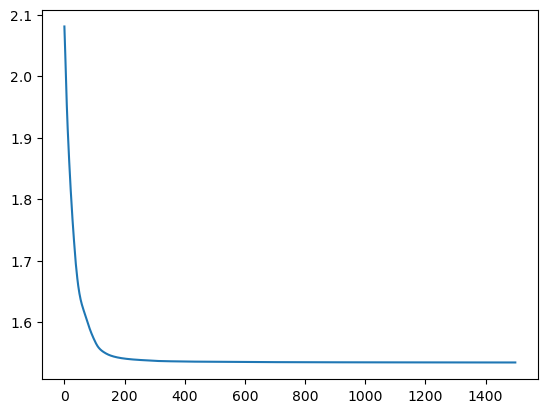

In [7]:
import torch.nn as nn

LEARNING_RATE = 0.001
EPOCHS = 1500

# Define the model
model = nn.Sequential(
    nn.Linear(x_train.shape[1], 1024),
    nn.ReLU(),
    nn.Linear(1024, len(action_folders)),
    nn.Softmax(dim=1),
)

# Scale weights based on class imbalance
class_weights = torch.tensor([1.0] * len(action_folders))
for i in range(len(action_folders)):
    class_weights[i] = len(y_train) / (len(action_folders) * np.sum(y_train == i))

loss_fn = nn.CrossEntropyLoss(
    weight=class_weights.float()
)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

losses = []

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    
    y_pred = model(torch.tensor(x_train).float())
    loss = loss_fn(y_pred, torch.tensor(y_train).long())
    losses.append(loss.item())
    
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch} Loss {loss.item()}")

model.eval()
y_pred = model(torch.tensor(x_train).float())
y_pred = torch.argmax(y_pred, dim=1)

# Evaluate training accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy on training set is {accuracy}")

# Plot the loss
import matplotlib.pyplot as plt

plt.plot(losses)

Number of cases below confidence score: 194
Total number of cases: 548
Accuracy on confident testing set is 0.923728813559322
              precision    recall  f1-score   support

           0       0.92      0.81      0.86        43
           1       0.95      0.84      0.89        44
           2       0.91      1.00      0.95        42
           3       0.96      0.92      0.94        53
           4       0.93      0.96      0.95        56
           5       0.79      0.97      0.87        38
           6       0.96      0.92      0.94        51
           7       1.00      0.96      0.98        27

    accuracy                           0.92       354
   macro avg       0.93      0.93      0.92       354
weighted avg       0.93      0.92      0.92       354

Accuracy on testing set is 0.8029197080291971
              precision    recall  f1-score   support

           0       0.92      0.63      0.75        76
           1       0.77      0.71      0.74        80
           2  

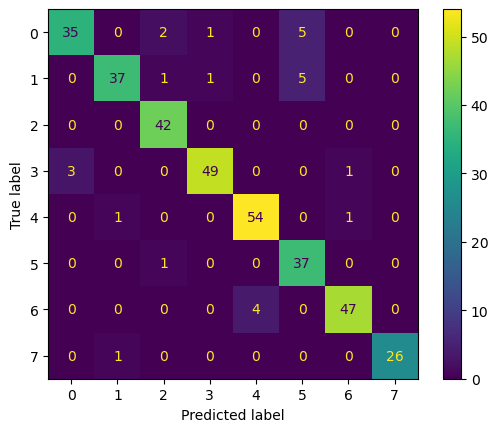

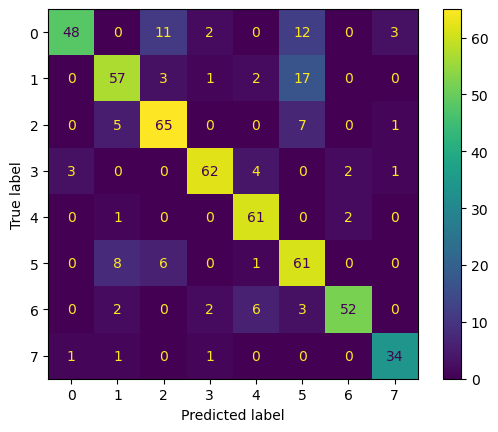

In [8]:
# Evaluate the model

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

model.eval()
y_pred = model(
    torch.tensor(x_test).float()
)  

CONFIDENCE_THRESHOLD = 0.7

# Convert matrix values to 0 if below CONFIDENCE_THRESHOLD
y_max = torch.max(y_pred, dim=1)
y_pred = torch.argmax(y_pred, dim=1)

# Get indices where y_max is less than CONFIDENCE_THRESHOLD and see the y_test of those indices
indices = y_max.values < CONFIDENCE_THRESHOLD
# print(y_test[indices])
print("Number of cases below confidence score: " + str(len(y_test[indices])))
print("Total number of cases: " + str(len(y_test)))
accuracy_confident = accuracy_score(y_test[~indices], y_pred[~indices])
print(f"Accuracy on confident testing set is {accuracy_confident}")

report_confident = classification_report(y_test[~indices], y_pred[~indices])
print(report_confident)

confusion_matrix(y_test[~indices], y_pred[~indices])
display = ConfusionMatrixDisplay(
    confusion_matrix(y_test[~indices], y_pred[~indices]), display_labels=range(len(action_folders))
)
display.plot()

# Evaluate the model on all test data
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on testing set is {accuracy}")

report = classification_report(y_test, y_pred)
print(report)

confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=range(len(action_folders)))

display.plot()

In [9]:
# Save the weights

weights_str = ""
biases_str = ""

for param in model.named_parameters():
    isBias = False
    if "0.weight" in param[0]:
        weights_str += ("custom_float input_weight[INPUT_NODES * HIDDEN_LAYER_NODES] = {")
        isBias = False
    if "0.bias" in param[0]:
        biases_str += ("custom_float input_bias[HIDDEN_LAYER_NODES] = {")
        isBias = True
    if "2.weight" in param[0]:
        weights_str += ("custom_float output_weight[HIDDEN_LAYER_NODES * OUTPUT_NODES] = {")
        isBias = False
    if "2.bias" in param[0]:
        biases_str += ("custom_float output_bias[OUTPUT_NODES] = {")
        isBias = True
        
    weight = param[1].detach().numpy().flatten().tolist()
    for w in weight:
        if isBias:
            biases_str += str(w) + ","
        else:
            weights_str += str(w) + ","
            
    if isBias:
        biases_str += "};\n\n"
    else:
        weights_str += "};\n\n"
        
print(weights_str)
print(biases_str)

custom_float input_weight[INPUT_NODES * HIDDEN_LAYER_NODES] = {0.022075030952692032,-0.004678724799305201,0.0014466742286458611,0.0065835025161504745,0.025491125881671906,0.027386920526623726,-0.00916675478219986,-0.014548048377037048,-0.014622287824749947,-0.021181181073188782,-0.00812724232673645,-0.014061893336474895,0.01763303019106388,-0.01857992447912693,-0.0033138205762952566,-0.014647490344941616,0.021205442026257515,0.004710182547569275,-0.023624541237950325,-0.0035427510738372803,-0.008474278263747692,-0.013263207860291004,-0.016176804900169373,-0.02578510157763958,0.002427655039355159,0.012654774822294712,0.002318084705621004,-0.011282578110694885,-0.01892257109284401,-0.03211454674601555,-0.015355184674263,0.0023332831915467978,-0.004875729791820049,-0.009307658299803734,-0.009052762761712074,-0.016940312460064888,0.00939702708274126,0.01931918039917946,0.0035630555357784033,-0.009631417691707611,-0.02040967345237732,-0.03169851377606392,-0.000569766154512763,-0.00181862164

In [10]:
# Generate test cases for HLS

random.seed(SEED)

TEST_CASES = 100

test_cases = []

for i in range(TEST_CASES):
    test_case = random.choice(x_test)
    test_cases.append(test_case)

test_cases = np.array(test_cases)
single_test_case = test_cases[12]

raw_output = model(torch.tensor(test_cases).float()).detach().numpy()
pred_output = np.argmax(raw_output, axis=1)
single_pred_output = pred_output[12]

test_cases_str = "float test_case[TEST_CASES_NUMBER * INPUT_NODES] = {"
pred_output_str = "int test_output[TEST_CASES_NUMBER] = {"

for test_case in test_cases.flatten():
    test_cases_str += str(test_case) + ","
for output in pred_output:
    pred_output_str += str(output) + ","

test_cases_str += "};\n"
pred_output_str += "};\n"

# print the test cases and the predicted output
print(test_cases_str)
print(pred_output_str)

float test_case[TEST_CASES_NUMBER * INPUT_NODES] = {-1.2490020541604674,-0.34630398789138456,-2.9845922206773805,-0.6940858955773337,-0.8329801329631025,-2.0717961785954255,1.6217198459039166,0.8198340776016342,-0.005885876036111632,0.9362281285344647,1.2292926646325997,2.1649681152724556,0.49647308552988295,0.10072925472462321,-1.3864478149534774,-0.24327237762961237,0.17451961753681217,-0.15104458000991747,2.4205609183376766,0.7709002600265227,2.0848539693774093,0.7457842557176924,0.774535645759077,2.250434444512471,1.3928238257696712,0.13373338764122872,0.947994789311056,0.4617594701416658,0.5410940713257226,1.5413434701225897,0.04416940006067971,0.3698517042076285,-0.33719353460009566,1.0658526220966416,-0.25930263853111046,2.0839794742323385,0.722892138164157,-0.5654236602271835,0.37661723335975755,0.1444473370499777,0.3073588987325719,0.8507451140769658,0.16926841962877243,-0.07473570741132013,0.07220022835787346,-0.02440976303917216,-0.026239851406030818,0.41409677309906906,-0.8

In [11]:
# Generate single test case for pynq testing

TEST_CASES = 3

test_cases = []

for i in range(TEST_CASES):
    test_case = random.choice(x_test)
    test_cases.append(test_case)
    
pred_output = model(torch.tensor(test_cases).float()).detach().numpy()

pred_output = np.argmax(pred_output, axis=1)

test_cases = np.array(test_cases)


test_cases_str = "input = ["
pred_output_str = "output = ["

for test_case in test_cases.flatten():
    test_cases_str += str(test_case) + ", "
for output in pred_output:
    pred_output_str += str(output) + ", "

test_cases_str += "]\n"
pred_output_str += "]\n"

# print the test cases and the predicted output
print(test_cases_str)
print(pred_output_str)

input = [-0.41431992332222234, 0.29982547939783394, 1.5113836187267435, 0.14209251867206588, 0.13608184768118042, 0.3707129706627974, -0.6713316538979934, -0.2000791233089689, 2.004417163635672, -0.03286919981722076, -0.09129606957619175, -0.48138331320125627, -0.6763282176122224, 0.04269593629945598, 2.285847990140874, 0.012388408356405483, 0.008895162719792378, -0.04622201046753331, -0.08052128667252273, -0.33457622627389716, 0.5074335880622357, -0.16572638295038342, -0.15758192273866803, -0.5566931421956071, -0.711127393712126, -0.5957799059562082, 2.0384119317755127, -0.2257411904953805, -0.25926995117944135, -0.5801297963731312, -0.12609022996792316, -0.3599764273716685, 0.19217086132772115, -0.09970132366096529, -0.0971763569305418, -0.4027508823765611, -0.8755042921927274, -0.6596767828635569, 2.5533824333462842, -0.2804120650078666, -0.37482455937799597, -0.49753692083969747, -0.18036602044541436, -0.15118647279032119, 1.1506310302830982, -0.06603842736121099, -0.08867221135316

C:\Users\tohmi\AppData\Local\Temp\ipykernel_18848\2179887874.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_e1nmgx0bk6\croot\pytorch-select_1725478824526\work\torch\csrc\utils\tensor_new.cpp:277.)
  pred_output = model(torch.tensor(test_cases).float()).detach().numpy()
